In [5]:
from google.colab import files
import zipfile

uploaded = files.upload()


Saving movie_review.zip to movie_review.zip


0.Optimization

In [10]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import cupy as cp
import re
import nltk
from sklearn.datasets import load_files
nltk.download('stopwords')
nltk.download('wordnet')
import pickle
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split

mr_zip = zipfile.ZipFile('movie_review.zip')
mr_zip.extractall('')
mr_zip.close()
review_data = load_files(r"movie_review")
X, y = review_data.data, review_data.target

documents = []

stemmer = WordNetLemmatizer()

for sen in range(0, len(X)):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(documents).toarray()

tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
X_train, X_test, y_train, y_test = cp.array(X_train), cp.array(X_test), cp.array(y_train), cp.array(y_test)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:
def distance(x, y):
    d = (x - y) ** 2
    s = np.sum(d)
    # r = np.sqrt(s)

    return(s)

def sigmoid(x):
    s = 1 + np.exp(-x)
    return cp.reciprocal(s)


In [20]:
lmbda = 0.5


In [43]:
class Layer:
  def __init__(self, size):
    self.size = size
    self.weight = cp.random.normal(size = (size[0], size[1]+1), scale = cp.sqrt(2/(size[0] + size[1])))
    self.a = cp.zeros(size[0])
    self.prev_l = None
  
  def predict(self, data):
    s = sigmoid(self.weight@cp.vstack((data, cp.ones((1, data.shape[1])))))
    return s
  def forward(self, data):
    self.a = cp.vstack((data, cp.ones((1, data.shape[1]))))
    s = sigmoid(self.weight @ self.a)
    return s

  def backwardPropagation(self, a, sigma, lr):
    sigma = sigma * (a * (1- a))
    num = sigma @ self.a.transpose()
    denom = self.a.shape[1] + lmbda * self.weight / a.shape[1]
    dx = num / denom
    self.prev_l = (dx)**2 if self.prev_l is None else (b * self.prev_l + (1 - b) * (dx**2))
    t = lr * (dx / cp.sqrt(self.prev_l) + eps)
    s = ((self.weight.transpose()@sigma)[:len(self.a)-1], self.a[:len(self.a)-1])
    return s

In [59]:
def run(a):
  sigma = (-y_train / a + (1 - y_train) / (1 - a))
  s = 0
  for layer in reversed(model):
    sigma, a = layer.backwardPropagation(a, sigma, lr)
    s += (layer.weight * layer.weight).sum()

  return s / (2 * a.shape[1] * lmbda)


In [60]:
lr = 0.0003
b = 0.9
eps = 1e-8

model = [Layer((300,1500)), Layer((1, 300))]

train_es = []
train_acs = []
test_es = []
test_acs = []

for i in range(5000):
  if i % 1000 == 0:
    print(i)
  
  temp1 = X_train.T
  temp2 = X_test.T

  for l in model:
    temp1 = l.forward(temp1)
    temp2 = l.predict(temp2)
  
  nxt = run(temp1)

  trcost = cp.mean(cp.sum(-y_train * cp.log(temp1) - (1-y_train) * cp.log(1-temp1), axis = 0)) + nxt
  tecost = cp.mean(cp.sum(-y_test * cp.log(temp2) - (1-y_test) * cp.log(1-temp2), axis = 0)) + nxt
  
  train_es.append(trcost)
  test_es.append(tecost)

  tracc = ((temp1 > 0.5) == y_train).mean()
  teacc = ((temp2 > 0.5) == y_test).mean()

  train_acs.append(tracc)
  test_acs.append(teacc)






0
1000
2000
3000
4000


1. Plot the loss curve

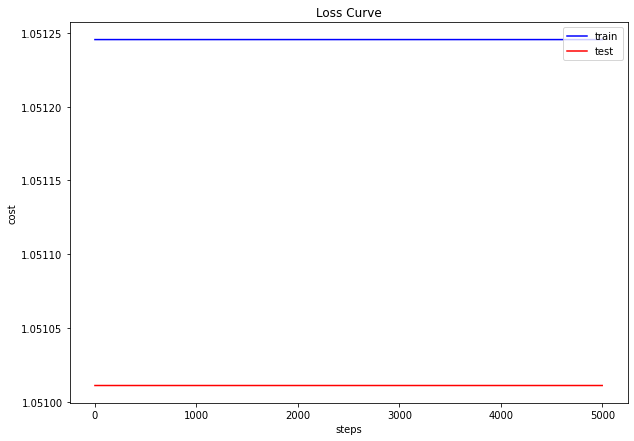

In [63]:
plt.figure(figsize=(10, 7))
plt.title("Loss Curve")
plt.plot(train_es, color='blue', label='train')
plt.plot(test_es, color='red', label='test')
plt.xlabel("steps")
plt.ylabel("cost")
plt.legend(loc='upper right')
plt.show()

2. Plot the accuracy curve


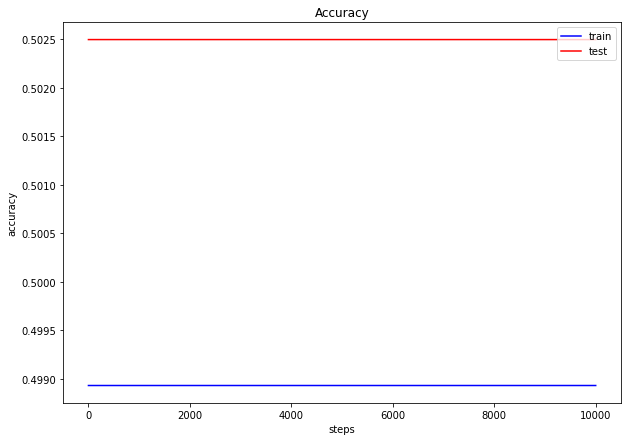

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.title("Accuracy")
plt.plot(train_acs, color='blue', label='train')
plt.plot(test_acs, color='red', label='test')
plt.xlabel("steps")
plt.ylabel("accuracy")
plt.legend(loc='upper right')
plt.show()


3. Plot the quantitative results

In [61]:
print('Accuracy Score : ', test_acs[-1] * 100, '%')

Accuracy Score :  52.74542429284526 %
